In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import torch
import generate as our
import generate_swift as swift
import numpy as np
from scipy.stats import norm
from scipy.optimize import curve_fit

/home/liutao/miniconda3/envs/instaflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/liutao/miniconda3/envs/instaflow/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## config

In [7]:
@dataclass
class GlobalConfig:
    sd_model_key = "/data/model/stable-diffusion-2-1-base"
    samples_num = 10
    key_t = [751,501,251,1]
    prompt = "a cute dog"
    curve_num = 3
    curve_name = ["SD","Ours w/o KL","Ours w/ KL","swift"]
    curve_style = "--"
    curve_color = ["orange","green","blue","cyan"]
    alpha = 1
    normal_color = "red"
    normal_name = r'$\mathcal{N}(0, 1)$'
    linewidth = 2
    swift_model_key = "/data/20231212/SwiftBrush_reproduce_final20231227/checkpoints/vsd_global_step4000.pth"
global_config = GlobalConfig()


@dataclass
class SdConfig:
    sd_key_t = [741,501,241,1]
    device = "cuda:0"
    sd_model_key = "/data/model/stable-diffusion-2-1-base"
    H = 512
    W = 512
    steps = 50
    t_range = [0.02, 0.98]
    batch_size = 8
    use_embeddings = False
    gradient_checkpointing = True
    dtype = torch.float32
    negative = ""
sd_config = SdConfig()

@dataclass
class OurConfig:
    base_path = "/data/"
    model_key = "/data/20231212/SwiftBrush_reproduce_se_parallel/checkpoints_20240228/vsd_global_step3000_4nis.pth"
    model_key_kl = "/data/20231212/SwiftBrush_reproduce_se_parallel/checkpoints_klloss/vsd_global_step42000_8nis_kl.pth"
    device = "cuda:0"
    step = 4
    step_kl = 8
our_config = OurConfig()


## ours

without kl

In [3]:
torch.cuda.empty_cache()
vae, tokenizer, text_encoder, unet, scheduler, alphas = our.load_model(our_config.base_path, our_config.model_key, our_config.device)
network = (vae, tokenizer, text_encoder, unet, scheduler)

our_data = {}
for key in global_config.key_t:
    our_data[str(key)] = []

for i in range(global_config.samples_num):
    noises = our.prompts_to_noises(student=network,prompt=global_config.prompt,num_inference_steps=our_config.step)
    for noise in noises:
        if noise["t"] in global_config.key_t:
            our_data[str(noise["t"].item())].extend(noise["value"].view(-1).tolist())

our_data_list = []
for key, value in our_data.items():
    our_data_list.append(value)
print(len(our_data_list),len(our_data_list[0]))

[INFO] loading student unet checkpoint


/home/liutao/miniconda3/envs/instaflow/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


4 819200


### with kl

In [4]:
torch.cuda.empty_cache()
vae, tokenizer, text_encoder, unet, scheduler, alphas = our.load_model(our_config.base_path, our_config.model_key_kl, our_config.device)
network_kl = (vae, tokenizer, text_encoder, unet, scheduler)

our_kl_data = {}
for key in global_config.key_t:
    our_kl_data[str(key)] = []

for i in range(global_config.samples_num):
    noises = our.prompts_to_noises(student=network_kl,prompt=global_config.prompt,num_inference_steps=our_config.step_kl)
    for noise in noises:
        if noise["t"] in global_config.key_t:
            our_kl_data[str(noise["t"].item())].extend(noise["value"].view(-1).tolist())

our_kl_data_list = []
for key, value in our_kl_data.items():
    our_kl_data_list.append(value)
print(len(our_kl_data_list),len(our_kl_data_list[0]))

[INFO] loading student unet checkpoint
4 163840


## sd

In [8]:
torch.cuda.empty_cache()
my_sd = sd.MyStableDiffusion(sd_config.device, global_config.sd_model_key, sd_config)

sd_data = {}
for key in sd_config.sd_key_t:
    sd_data[str(key)] = []

for i in range(global_config.samples_num):
    noises = my_sd.prompts_to_noises(global_config.prompt, sd_config.negative, sd_config.H, sd_config.W, sd_config.steps, guidance_scale=1.0)
    for noise in noises:
        if noise["t"] in sd_config.sd_key_t:
            sd_data[str(noise["t"].item())].extend(noise["value"].view(-1).tolist())

sd_data_list = []
for key, value in sd_data.items():
    sd_data_list.append(value)
print(len(sd_data_list),len(sd_data_list[0]))


[INFO] loading stable diffusion...
[INFO] loaded stable diffusion!
4 163840


## swift

In [9]:
torch.cuda.empty_cache()
vae, tokenizer, text_encoder, unet, alphas = swift.load_model("/data/", "/data/20231212/SwiftBrush_reproduce_final20231227/checkpoints/vsd_global_step4000.pth")
swift_network = (vae, tokenizer, text_encoder, unet)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 23.70 GiB of which 8.56 MiB is free. Process 2986240 has 251.00 MiB memory in use. Including non-PyTorch memory, this process has 23.44 GiB memory in use. Of the allocated memory 21.80 GiB is allocated by PyTorch, and 203.42 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
swift_data = []
for i in range(global_config.samples_num):
    noises = swift.prompts_to_noises(student=swift_network,prompt=global_config.prompt).cpu()
    swift_data.extend(noises.view(-1).tolist())

swift_data_list = []
for i in range(4):
    swift_data_list.append(swift_data)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


## draw

/tmp/ipykernel_3012510/2448952241.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


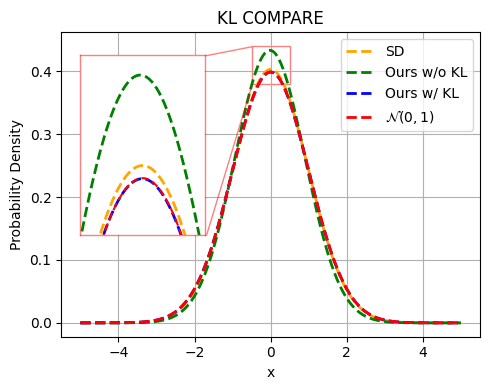

In [13]:
from matplotlib.patches import Rectangle

rect_linewidth = 1
rect_color = 'red'
rect_style = '-'
rect_alpha = 0.5

# Generate x values
x = np.linspace(-5, 5, 1000)

# Define the standard normal distribution
y_std = norm.pdf(x, 0, 1)
    
# Define the non-standard normal distribution function
def non_standard_normal(x, mu, sigma):
    return norm.pdf(x, mu, sigma)

# Create the main figure and plot
fig, ax_main = plt.subplots(figsize=(5, 4))

data = [sd_data_list[0], our_data_list[0], our_kl_data_list[0]]
for j in range(global_config.curve_num):
    # Get the mean and standard deviation of the data
    mu_data = np.mean(data[j])
    sigma_data = np.std(data[j])
    # Fit the non-standard normal distribution to the data
    params, _ = curve_fit(non_standard_normal, x, norm.pdf(x, mu_data, sigma_data))

    # Plot the fitted non-standard normal distribution on the main figure
    ax_main.plot(
        x, non_standard_normal(x, *params), global_config.curve_style,color=global_config.curve_color[j],
        label=global_config.curve_name[j], linewidth=global_config.linewidth, alpha=global_config.alpha
    )

# Plot the standard normal distribution on the main figure
ax_main.plot(x, y_std, global_config.curve_style, color=global_config.normal_color, label=global_config.normal_name, linewidth=global_config.linewidth, alpha=global_config.alpha)
    
# Plot red rect
rectangle = Rectangle((-0.5, 0.38), 1, 0.06, edgecolor='r', facecolor='none', linewidth=1, alpha=rect_alpha)
ax_main.add_patch(rectangle)

# Plot line
ax_main.plot([-1.68, -0.5], [0.14, 0.376], color=rect_color, linestyle=rect_style, linewidth=rect_linewidth, alpha=rect_alpha)  
ax_main.plot([-1.68, -0.5], [0.425, 0.439], color=rect_color, linestyle=rect_style, linewidth=rect_linewidth, alpha=rect_alpha)  


# Set labels and title for the main figure
ax_main.set_title('KL COMPARE')
ax_main.set_xlabel('x')
ax_main.set_ylabel('Probability Density')
ax_main.legend()
ax_main.grid(True)


# Create the inset figure for the zoomed view
fig.subplots_adjust(right=0.8)  # Adjust the right side spacing to make space for the inset

ax_inset = fig.add_axes([0.17, 0.4, 0.25, 0.45])  # Define the inset position

# Plot the zoomed data in the inset figure

for j in range(global_config.curve_num):
    # Get the mean and standard deviation of the data
    mu_data = np.mean(data[j])
    sigma_data = np.std(data[j])
    # Fit the non-standard normal distribution to the data
    params, _ = curve_fit(non_standard_normal, x, norm.pdf(x, mu_data, sigma_data))

    # Plot the fitted non-standard normal distribution on the main figure
    ax_inset.plot(
        x, non_standard_normal(x, *params), global_config.curve_style, color=global_config.curve_color[j],
        label=global_config.curve_name[j], linewidth=global_config.linewidth, alpha=1
    )

ax_inset.plot(x, y_std, global_config.curve_style, color=global_config.normal_color, alpha=1)

# Set limits for the inset x-axis to zoom in on the peak
ax_inset.set_xlim(-0.5, 0.5)
ax_inset.set_ylim(0.38, 0.44)


# Set ticks and labels for the inset figure
ax_inset.tick_params(axis='both', which='major', labelsize=6)
ax_inset.set_xticks([])
ax_inset.set_yticks([])

for spine in ax_inset.spines.values():
    spine.set_visible(True)
    spine.set_color('red')
    spine.set_linewidth(1)
    spine.set_linestyle('-')
    spine.set_alpha(rect_alpha)
    

plt.tight_layout()
# plt.show()

dpi = 600  # 设置为300像素/英寸，可以根据需要调整
# # 保存为 PDF 文件
plt.savefig('KL.pdf', format='pdf')
plt.savefig('KL.png', dpi=dpi, bbox_inches='tight')  # 保存为高清图像


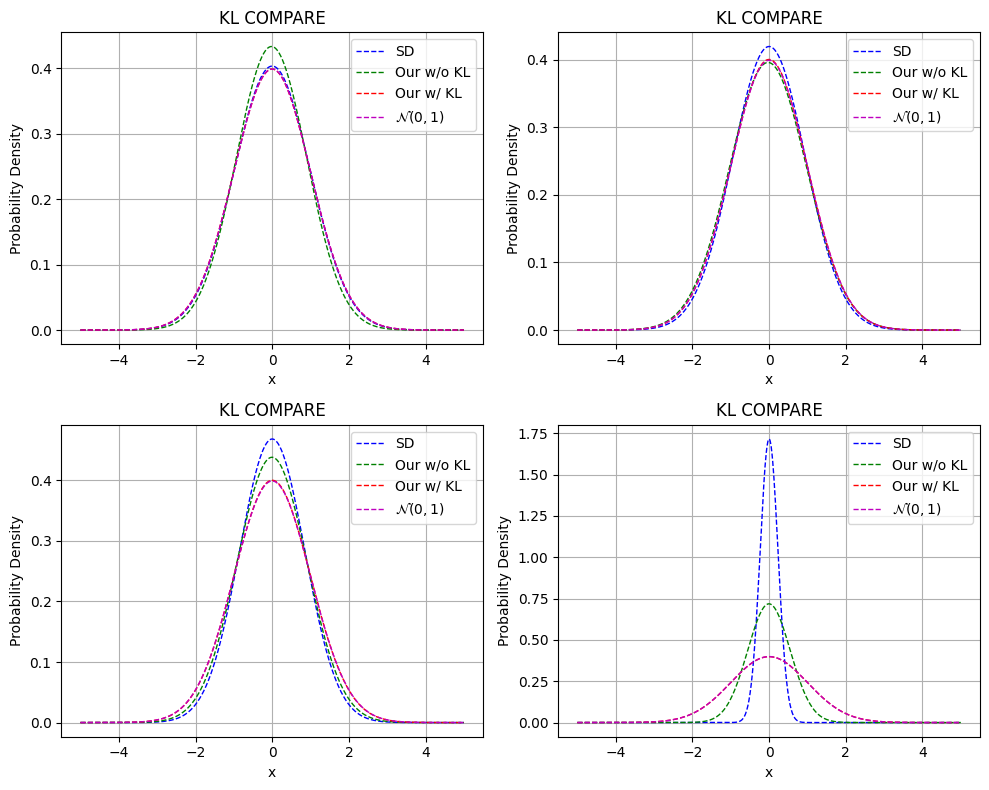

In [ ]:
# Generate x values
x = np.linspace(-5, 5, 1000)

# Define the standard normal distribution
y_std = norm.pdf(x, 0, 1)

# Define the non-standard normal distribution function
def non_standard_normal(x, mu, sigma):
    return norm.pdf(x, mu, sigma)


# Create four identical plots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))


for i, ax in enumerate(axs.flat):
    data = [sd_data_list[i],our_data_list[i],our_kl_data_list[i],swift_data_list[i]]
    for j in range(global_config.curve_num):
        # Get the mean and standard deviation of the data
        mu_data = np.mean(data[j])
        sigma_data = np.std(data[j])
        # Fit the non-standard normal distribution to the data
        params, _ = curve_fit(non_standard_normal, x, norm.pdf(x, mu_data, sigma_data))
        
        
        # Plot the fitted non-standard normal distribution
        ax.plot(x, non_standard_normal(x, *params), global_config.curve_style[j], label=global_config.curve_name[j], linewidth=global_config.linewidth)
    
    # Plot the standard normal distribution
    ax.plot(x, y_std, global_config.normal_style, label=global_config.normal_name, linewidth=global_config.linewidth)

    ax.set_title('KL COMPARE')
    ax.set_xlabel('x')
    ax.set_ylabel('Probability Density')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()
